In [1]:
import numpy as np
from scipy.linalg import svd, hankel, eig
from matplotlib import pyplot as plt
import scipy
from tqdm import trange
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.io import savemat

In [2]:
np.random.seed(999)
Tmaxs = np.array([1000])
noises = [1.0]

In [3]:
for Tmax in Tmaxs:
    for noise in noises:
        overlap = 0.2  # 0: HF
        dt = 1

        def generate_samples(E, psi0, dt=1, nb=100):
            S = np.zeros(nb, dtype=np.complex128)
            for j in trange(nb):
                S[j] = np.sum(np.abs(psi0)**2 * np.exp(-1j * E * j * dt))
            return S

        def lam2lamt(lam, lammin, lammax):
            lamt = np.pi / 2 * (lam - (lammin + lammax) / 2) / (lammax - lammin)
            return lamt

        def generate_phi(overlap, N):
            phi = np.zeros((N, 1))
            phi[0] = np.sqrt(overlap)
            phi[1:] = np.sqrt((1 - phi[0]**2) / (N - 1))
            return phi

        data_cr2 = scipy.io.loadmat('../../data/Cr2_4000.mat')
        E = data_cr2['E']
        Et = lam2lamt(E, E[0], E[-1])

       
        phi = generate_phi(overlap, len(Et))
        print('generated phi')
        dataS = generate_samples(Et, phi, dt, Tmax)

        tdataS = []
        num_trajs = 1000
        for i in range(num_trajs):
            ndataS = (dataS + noise * np.random.randn(Tmax) + 1j * noise * np.random.randn(Tmax))
            tdataS.append(ndataS)
        noisydataS = np.array(tdataS)

        t = np.arange(0, Tmax, 1)
        # Average the noisy signals
        average_noisy_signal = np.mean(noisydataS, axis=0)

        # Fit GP to the averaged real part of the signal
        X = t[:, np.newaxis]
        y_real = average_noisy_signal.real
        kernel = C(1.0, (1e-6, 1e1)) * RBF(1.0, (1e-4, 1e1))
        gp_real = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1.0/num_trajs)
        gp_real.fit(X, y_real)
        mean_real_prediction, std_real_prediction= gp_real.predict(X, return_std=True)

        # Fit GP to the averaged imaginary part of the signal
        y_imag = average_noisy_signal.imag
        gp_imag = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1.0/num_trajs)
        gp_imag.fit(X, y_imag)
        mean_imag_prediction, std_imag_prediction = gp_imag.predict(X, return_std=True)

        # Combine real and imaginary predictions
        mean_prediction = mean_real_prediction + 1j * mean_imag_prediction

        # Save the denoised complex signal
        #savemat('../../matlab/denoised_data/denoised_dataS_LiH_GP_Tmax=' + str(Tmax) + '_overlap=' + str(overlap) + 'noise=' + str(noise) + '_complex.mat', {'denoised_dataS': mean_prediction})

generated phi


100%|██████████| 1000/1000 [00:00<00:00, 7695.46it/s]


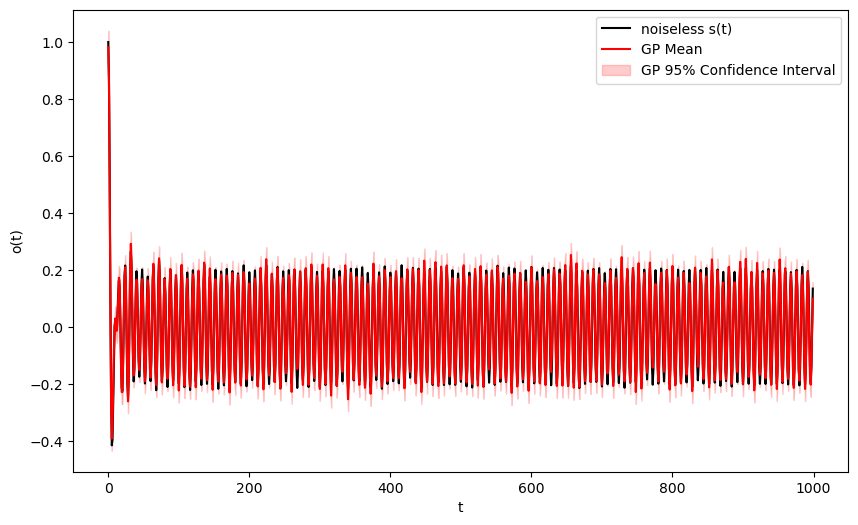

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(t, dataS.real, 'black', label='noiseless s(t)')
plt.plot(t, mean_prediction.real, 'r-', label='GP Mean')
plt.fill_between(t, mean_prediction.real - 2*std_real_prediction, mean_prediction.real + 2*std_real_prediction, color='r', alpha=0.2, label='GP 95% Confidence Interval')
plt.xlabel('t')
plt.ylabel('o(t)')
plt.legend()

In [5]:
# Step 1: Extract Posterior Variance
X = np.arange(0, Tmax, 1)[:, np.newaxis]
mean_real_prediction, cov_real_matrix  = gp_real.predict(X, return_cov=True)
mean_real_prediction, sigma_real_prediction  = gp_real.predict(X, return_std=True)
#mean_imag_prediction, sigma_imag_prediction = gp_imag.predict(X, return_std=True)

In [6]:
K_real = cov_real_matrix

In [7]:
# For the real part
from scipy.linalg import det
det_K_real = det(K_real + np.eye(len(K_real)) * noise)

In [8]:
# # For the imaginary part
# det_K_imag = det(K_imag + np.eye(len(K_imag)) * noise)

7.819347328958233
True
7.106812394448809
True
6.299322338659672
True


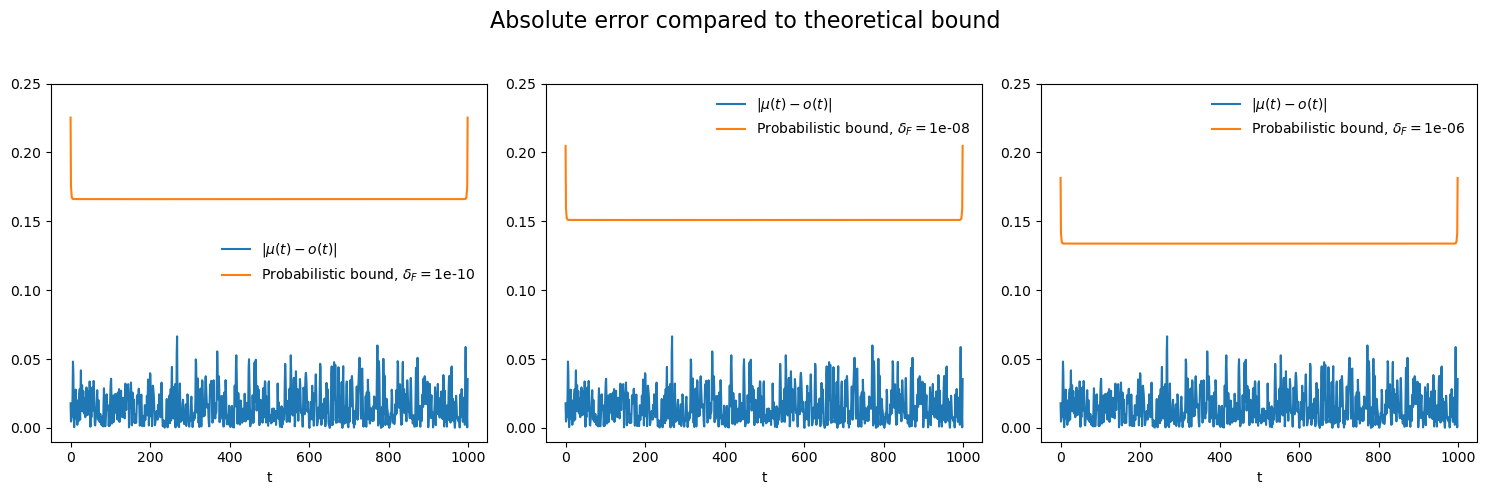

In [56]:
deltas = [1e-10, 1e-8, 1e-6]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, delta in enumerate(deltas):
    B = 1.0  # Bound on the RKHS norm ||f||_k
    R = noise  # R-subgaussian parameter
    lambda_ = max(1, noise)
    
    # Compute the beta term
    beta_n_real = B + R * np.sqrt(np.log(det_K_real) - 2 * np.log(delta))
    print(beta_n_real)
    bound_real = beta_n_real * sigma_real_prediction
    
    # Plot the data on the corresponding subplot
    axs[i].plot(np.abs(dataS.real - mean_prediction.real))
    axs[i].plot(bound_real)
    axs[i].set_xlabel('t')
    axs[i].legend([r'$|\mu(t) - o(t)|$', r'Probabilistic bound, $\delta_F = $'+str(delta)], frameon=False)
    
    print(all(np.abs(dataS.real - mean_prediction.real) < bound_real))


fig.suptitle('Absolute error compared to theoretical bound', fontsize=16)
[ax.set_ylim([-0.01, 0.25]) for ax in axs]
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('gif_figs/fielder_bound_vs_abs_err_combined_Cr2_delta=1e-10_1e-08_1e-06.png')

In [73]:
overlapprime = 0.35
phiprime = generate_phi(overlapprime,len(Et));
print('generated phi')
dataSprime = generate_samples(Et,phiprime,dt,Tmax);

generated phi


100%|██████████| 1000/1000 [00:00<00:00, 7827.38it/s]


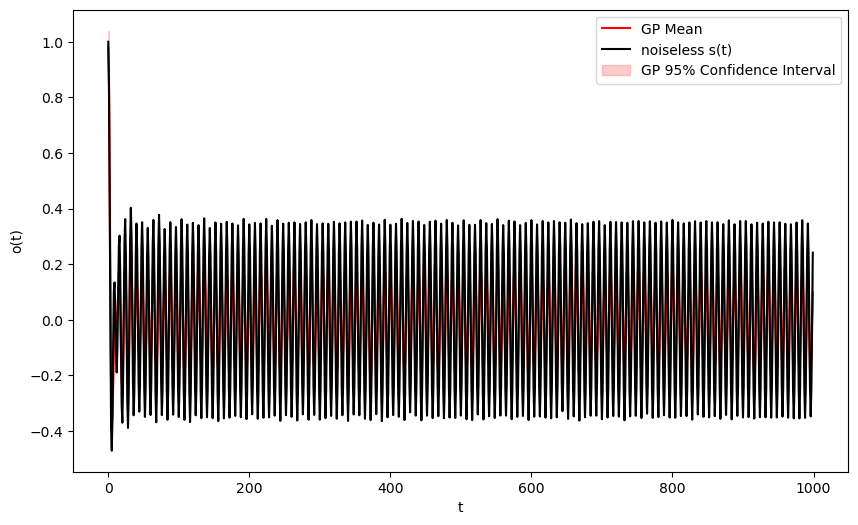

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(t, mean_real_prediction.real, 'r-', label='GP Mean')
plt.plot(t, dataSprime[:Tmax].real, 'black', label='noiseless s(t)')
plt.fill_between(t, mean_real_prediction.real - 2*sigma_real_prediction, mean_real_prediction.real + 2*sigma_real_prediction, color='r', alpha=0.2, label='GP 95% Confidence Interval')
plt.xlabel('t')
plt.ylabel('o(t)')
plt.legend()

7.819347328958233
False
7.106812394448809
False
6.299322338659672
False


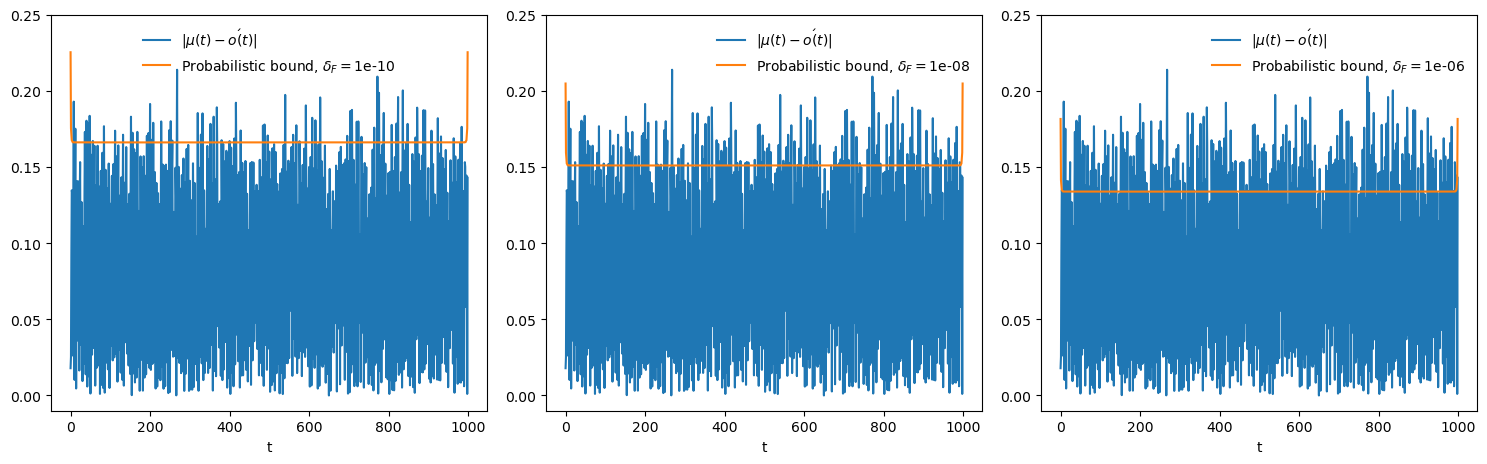

In [75]:
deltas = [1e-10, 1e-8, 1e-6]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, delta in enumerate(deltas):
    B = 1.0  # Bound on the RKHS norm ||f||_k
    R = noise  # R-subgaussian parameter
    lambda_ = max(1, noise)
    
    # Compute the beta term
    beta_n_real = B + R * np.sqrt(np.log(det_K_real) - 2 * np.log(delta))
    print(beta_n_real)
    bound_real = beta_n_real * sigma_real_prediction
    
    # Plot the data on the corresponding subplot
    axs[i].plot(np.abs(dataSprime.real - mean_prediction.real))
    axs[i].plot(bound_real)
    axs[i].set_xlabel('t')
    axs[i].legend([r'$|\mu(t) - o\'(t)|$', r'Probabilistic bound, $\delta_F = $'+str(delta)], frameon=False)
    
    print(all(np.abs(dataSprime.real - mean_prediction.real) < bound_real))


#fig.suptitle('Absolute error compared to theoretical bound', fontsize=16)
[ax.set_ylim([-0.01, 0.25]) for ax in axs]
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('gif_figs/fielder_bound_vs_abs_err_combined_Cr2_delta=1e-10_1e-08_1e-06_p0=0.35.png')

In [13]:
delta_p = np.sum(np.abs(phiprime**2 - phi**2))
delta_p

0.0

generated phi


100%|██████████| 1000/1000 [00:00<00:00, 5499.49it/s]


True
generated phi


100%|██████████| 1000/1000 [00:00<00:00, 5419.35it/s]


True
generated phi


100%|██████████| 1000/1000 [00:00<00:00, 6122.63it/s]


True
generated phi


100%|██████████| 1000/1000 [00:00<00:00, 6121.12it/s]


True
generated phi


100%|██████████| 1000/1000 [00:00<00:00, 6139.09it/s]


True
generated phi


100%|██████████| 1000/1000 [00:00<00:00, 5396.39it/s]


True
generated phi


100%|██████████| 1000/1000 [00:00<00:00, 5406.19it/s]

True


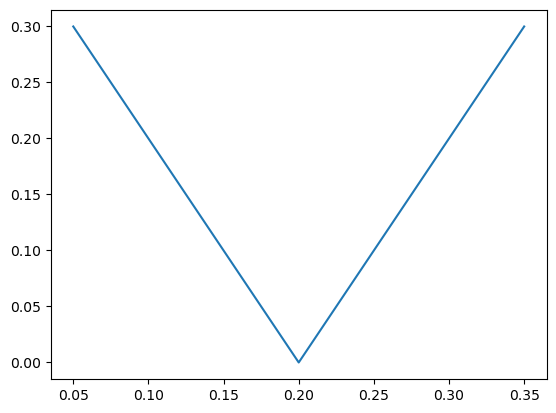

In [14]:
test_overlaps = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
delta_ps = []
for k in range(len(test_overlaps)):
    
    overlapprime = test_overlaps[k]
    phiprime = generate_phi(overlapprime,len(Et));
    print('generated phi')
    dataSprime = generate_samples(Et,phiprime,dt,Tmax);
    delta_p = np.sum(np.abs(np.abs(phiprime)**2 - np.abs(phi)**2))
    print( all(np.abs(dataS.real - mean_prediction.real) < bound_real))
    delta_ps.append(delta_p)
plt.plot(test_overlaps, delta_ps)